-------PREPARING ENVIRONMENT--------

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 13 17:39:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    41W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


--------DATA PREPROCESSING--------------

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the CSV file using numpy.genfromtxt()
data = np.genfromtxt('/content/gdrive/MyDrive/Bakalauras/train_data_RR_1_05_31_newest.csv', delimiter=',')

In [ ]:
data = np.delete(data, 0, axis=0)
data = np.delete(data, 0, axis=1)

train_labels = data[:, 1]
train_data = np.delete(data, 1, axis=1)

print("Initial data")
print("Class 0:")
print(np.count_nonzero(train_labels == 0))
print("Class 1:")
print(np.count_nonzero(train_labels == 1))
print("Class 2:")
print(np.count_nonzero(train_labels == 2))
print("Initial data length:")
print(len(train_labels))

faulty_indices = np.where(train_labels == 3)
faulty_indices = faulty_indices[0].tolist()

train_labels = np.delete(train_labels,[faulty_indices],axis=0)
train_data = np.delete(train_data,[faulty_indices],axis=0)

print("Initial data length (no noise):")
print(len(train_labels))

# Split the data into training and validation sets
train_data, validation_data, train_labels, validation_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

print("Training data")
print("Class 0:")
print(np.count_nonzero(train_labels == 0))
print("Class 1:")
print(np.count_nonzero(train_labels == 1))
print("Class 2:")
print(np.count_nonzero(train_labels == 2))
print("Training data length:")
print(len(train_labels))

print("Validation data")
print("Class 0:")
print(np.count_nonzero(validation_labels == 0))
print("Class 1:")
print(np.count_nonzero(validation_labels == 1))
print("Class 2:")
print(np.count_nonzero(validation_labels == 2))
print("Validation data length:")
print(len(validation_labels))

Initial data
Class 0:
221498
Class 1:
2420
Class 2:
6177
Initial data length:
230109
Initial data length (no noise):
230095
Training data
Class 0:
177184
Class 1:
1932
Class 2:
4960
Training data length:
184076
Validation data
Class 0:
44314
Class 1:
488
Class 2:
1217
Validation data length:
46019


----------DATA BALANCING----------

In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
smote_train_data, smote_labels = smote.fit_resample(train_data, train_labels)

print("SMOTE balanced data")
print("Class 0:")
print(np.count_nonzero(smote_labels == 0))
print("Class 1:")
print(np.count_nonzero(smote_labels == 1))
print("Class 2:")
print(np.count_nonzero(smote_labels == 2))
print("SMOTE data length:")
print(len(smote_labels))

SMOTE balanced data
Class 0:
177184
Class 1:
177184
Class 2:
177184
SMOTE data length:
531552


In [ ]:
# RANDOM OVERSAMPLING
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=42)
random_oversampling_train_data, random_oversampling_labels = oversample.fit_resample(train_data, train_labels)

print("RANDOM OVERSAMPLING balanced data")
print("Class 0:")
print(np.count_nonzero(random_oversampling_labels == 0))
print("Class 1:")
print(np.count_nonzero(random_oversampling_labels == 1))
print("Class 2:")
print(np.count_nonzero(random_oversampling_labels == 2))
print("RANDOM OVERSAMPLING data length:")
print(len(random_oversampling_labels))

RANDOM OVERSAMPLING balanced data
Class 0:
177184
Class 1:
177184
Class 2:
177184
RANDOM OVERSAMPLING data length:
531552


In [ ]:
# RANDOM UNDERSAMPLING
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(random_state=42)
random_undersampling_train_data, random_undersampling_labels = undersample.fit_resample(train_data, train_labels)


print("RANDOM UNDERSAMPLING balanced data")
print("Class 0:")
print(np.count_nonzero(random_undersampling_labels == 0))
print("Class 1:")
print(np.count_nonzero(random_undersampling_labels == 1))
print("Class 2:")
print(np.count_nonzero(random_undersampling_labels == 2))
print("RANDOM UNDERSAMPLING data length:")
print(len(random_undersampling_labels))

RANDOM UNDERSAMPLING balanced data
Class 0:
1932
Class 1:
1932
Class 2:
1932
RANDOM UNDERSAMPLING data length:
5796


--------TRAINING---------

In [ ]:
from tensorflow import keras

# Import provided model
model = keras.models.load_model('/content/gdrive/MyDrive/Bakalauras/best_model_final.h5')

In [ ]:
import matplotlib.pyplot as plt

def train(train_data, train_labels, validation_data, validation_labels):
    # Copying layers from the provided model
    new_model = keras.models.clone_model(model)

    early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0,
      patience=5,
      verbose=0,
      mode='auto',
      baseline=None,
      restore_best_weights=True
    )

    # Compiling - adding optimizer, loss function, metrics
    new_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy(), "MAE"],
    )

    # Training
    history = new_model.fit(
        train_data,
        train_labels,
        epochs=10,
        validation_data=(validation_data, validation_labels),
        callbacks=[early_stopping_monitor]
    )


    # Plotting model accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Plotting model loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    return new_model


Training primary model
Epoch 1/10
5753/5753 [==============================] - 103s 17ms/step - loss: 0.0586 - sparse_categorical_accuracy: 0.9816 - MAE: 0.3728 - val_loss: 0.0587 - val_sparse_categorical_accuracy: 0.9886 - val_MAE: 0.3721
Epoch 2/10
5753/5753 [==============================] - 97s 17ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9907 - MAE: 0.3728 - val_loss: 0.0713 - val_sparse_categorical_accuracy: 0.9837 - val_MAE: 0.3721
Epoch 3/10
5753/5753 [==============================] - 97s 17ms/step - loss: 0.0267 - sparse_categorical_accuracy: 0.9921 - MAE: 0.3728 - val_loss: 0.0263 - val_sparse_categorical_accuracy: 0.9923 - val_MAE: 0.3721
Epoch 4/10
5753/5753 [==============================] - 96s 17ms/step - loss: 0.0233 - sparse_categorical_accuracy: 0.9935 - MAE: 0.3728 - val_loss: 0.0486 - val_sparse_categorical_accuracy: 0.9843 - val_MAE: 0.3721
Epoch 5/10
5753/5753 [==============================] - 96s 17ms/step - loss: 0.0211 - sparse_categorical_accura

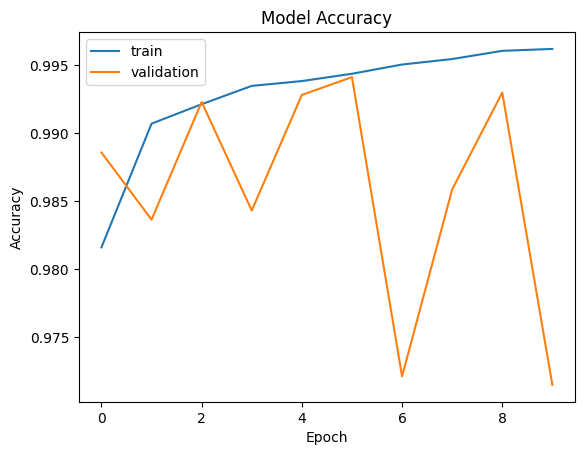

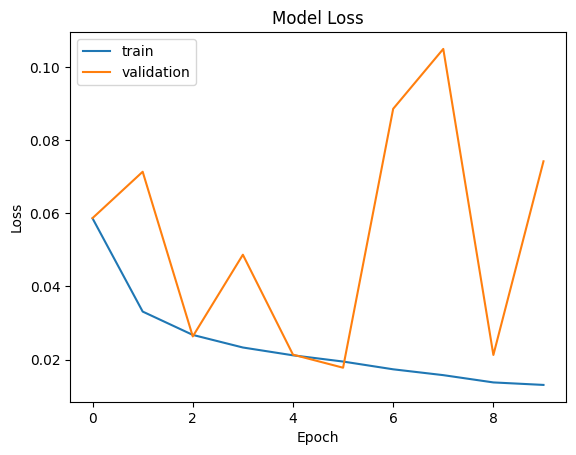

Training SMOTE model
Epoch 1/10
16611/16611 [==============================] - 238s 14ms/step - loss: 0.0826 - sparse_categorical_accuracy: 0.9743 - MAE: 0.8889 - val_loss: 0.0885 - val_sparse_categorical_accuracy: 0.9752 - val_MAE: 0.3721
Epoch 2/10
16611/16611 [==============================] - 231s 14ms/step - loss: 0.0234 - sparse_categorical_accuracy: 0.9935 - MAE: 0.8889 - val_loss: 0.8434 - val_sparse_categorical_accuracy: 0.6595 - val_MAE: 0.3721
Epoch 3/10
16611/16611 [==============================] - 231s 14ms/step - loss: 0.0151 - sparse_categorical_accuracy: 0.9958 - MAE: 0.8889 - val_loss: 0.1156 - val_sparse_categorical_accuracy: 0.9678 - val_MAE: 0.3721
Epoch 4/10
16611/16611 [==============================] - 231s 14ms/step - loss: 0.0115 - sparse_categorical_accuracy: 0.9969 - MAE: 0.8889 - val_loss: 0.1213 - val_sparse_categorical_accuracy: 0.9671 - val_MAE: 0.3721
Epoch 5/10
16611/16611 [==============================] - 231s 14ms/step - loss: 0.0090 - sparse_catego

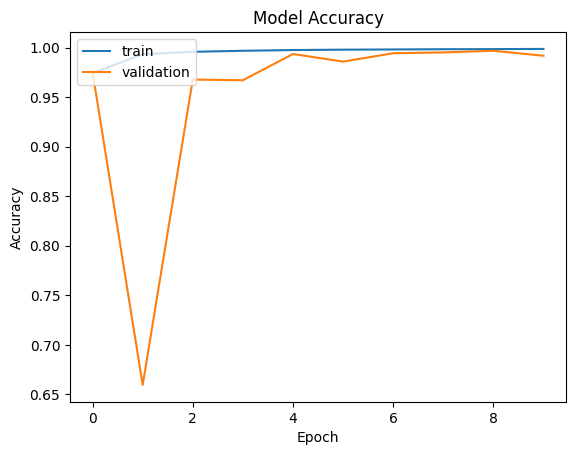

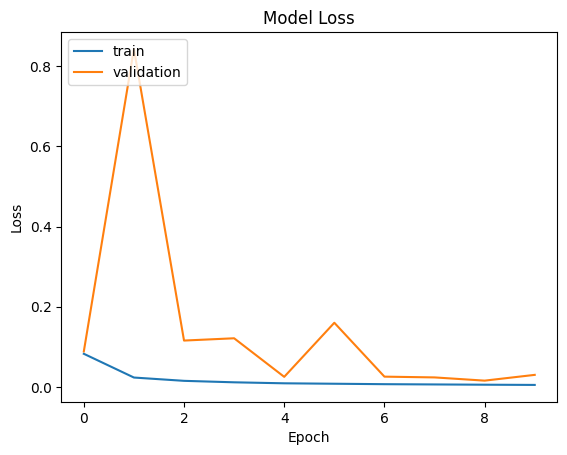

Training random oversampling model
Epoch 1/10
16611/16611 [==============================] - 239s 14ms/step - loss: 0.1098 - sparse_categorical_accuracy: 0.9633 - MAE: 0.8889 - val_loss: 0.0713 - val_sparse_categorical_accuracy: 0.9798 - val_MAE: 0.3721
Epoch 2/10
16611/16611 [==============================] - 230s 14ms/step - loss: 0.0277 - sparse_categorical_accuracy: 0.9924 - MAE: 0.8889 - val_loss: 0.0337 - val_sparse_categorical_accuracy: 0.9909 - val_MAE: 0.3721
Epoch 3/10
16611/16611 [==============================] - 231s 14ms/step - loss: 0.0165 - sparse_categorical_accuracy: 0.9956 - MAE: 0.8889 - val_loss: 0.0332 - val_sparse_categorical_accuracy: 0.9915 - val_MAE: 0.3721
Epoch 4/10
16611/16611 [==============================] - 231s 14ms/step - loss: 0.0122 - sparse_categorical_accuracy: 0.9968 - MAE: 0.8889 - val_loss: 0.0228 - val_sparse_categorical_accuracy: 0.9946 - val_MAE: 0.3721
Epoch 5/10
16611/16611 [==============================] - 230s 14ms/step - loss: 0.0097 -

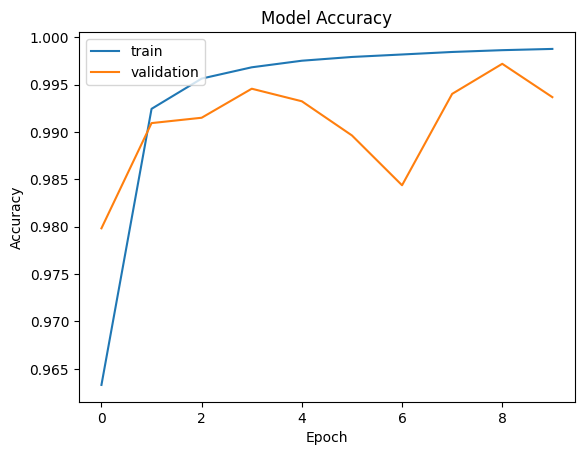

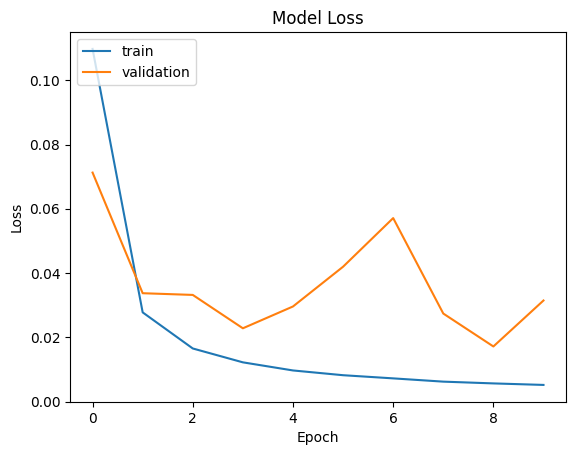

Training random undersampling model
Epoch 1/10
182/182 [==============================] - 19s 60ms/step - loss: 0.7148 - sparse_categorical_accuracy: 0.6366 - MAE: 0.8889 - val_loss: 0.4702 - val_sparse_categorical_accuracy: 0.8354 - val_MAE: 0.3721
Epoch 2/10
182/182 [==============================] - 10s 54ms/step - loss: 0.5816 - sparse_categorical_accuracy: 0.7359 - MAE: 0.8889 - val_loss: 0.1286 - val_sparse_categorical_accuracy: 0.9585 - val_MAE: 0.3721
Epoch 3/10
182/182 [==============================] - 10s 54ms/step - loss: 0.5133 - sparse_categorical_accuracy: 0.8135 - MAE: 0.8889 - val_loss: 0.1619 - val_sparse_categorical_accuracy: 0.9589 - val_MAE: 0.3721
Epoch 4/10
182/182 [==============================] - 10s 54ms/step - loss: 0.4805 - sparse_categorical_accuracy: 0.8261 - MAE: 0.8889 - val_loss: 0.3028 - val_sparse_categorical_accuracy: 0.9039 - val_MAE: 0.3721
Epoch 5/10
182/182 [==============================] - 10s 54ms/step - loss: 0.4298 - sparse_categorical_accu

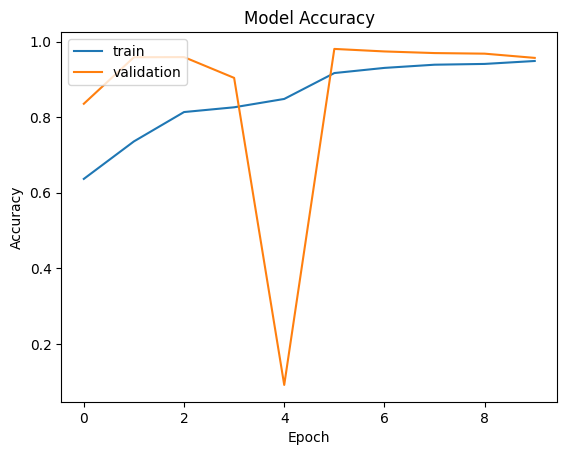

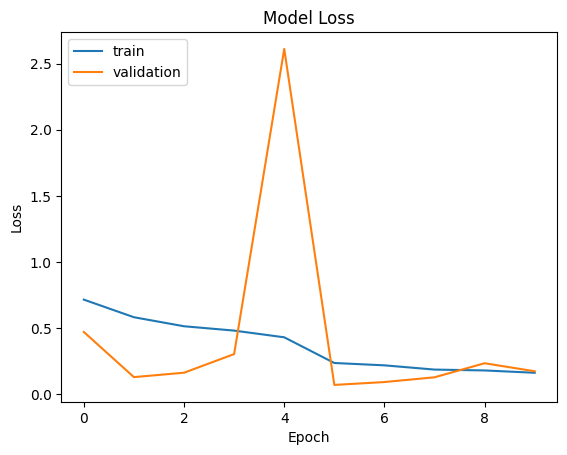

In [ ]:
# After training the model, save with proper naming - For example, for SMOTE balancing, name the model - "SMOTE_model.h5"
print("Training primary model")
primary_model = train(train_data, train_labels, validation_data, validation_labels)
print("Training SMOTE model")
smote_model = train(smote_train_data, smote_labels, validation_data, validation_labels)
print("Training random oversampling model")
random_oversampling_model = train(random_oversampling_train_data, random_oversampling_labels, validation_data, validation_labels)
print("Training random undersampling model")
random_undersampling_model = train(random_undersampling_train_data, random_undersampling_labels, validation_data, validation_labels)

primary_model.save('/content/gdrive/MyDrive/Bakalauras/primary_model.h5')
smote_model.save('/content/gdrive/MyDrive/Bakalauras/smote_model.h5')
random_oversampling_model.save('/content/gdrive/MyDrive/Bakalauras/random_oversampling_model.h5')
random_undersampling_model.save('/content/gdrive/MyDrive/Bakalauras/random_undersampling_model.h5')

-----------TESTING-------

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)

# PREPARING TEST DATA
test_data = np.genfromtxt('/content/gdrive/MyDrive/Bakalauras/test_data_RR_1_05_31_newest.csv', delimiter=',')

test_data = np.delete(test_data, 0, axis=0)
test_data = np.delete(test_data, 0, axis=1)

test_labels = test_data[:, 1]

test_data = np.delete(test_data, 1, axis=1)

print("Testing data")
print("Class 0:")
print(np.count_nonzero(test_labels == 0))
print("Class 1:")
print(np.count_nonzero(test_labels == 1))
print("Class 2:")
print(np.count_nonzero(test_labels == 2))
print("Testing data length:")
print(len(test_labels))

faulty_indices = np.where(test_labels == 3)
faulty_indices = faulty_indices[0].tolist()

test_labels = np.delete(test_labels,[faulty_indices],axis=0)
test_data = np.delete(test_data,[faulty_indices],axis=0)

print("Testing data length (no noise):")
print(len(test_labels))

Testing data
Class 0:
77121
Class 1:
1257
Class 2:
2484
Testing data length:
80862
Testing data length (no noise):
80862


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def test(model):
    results = model.evaluate(test_data, test_labels)
    print("test loss, test acc:", results)
  
    y_pred = model.predict(test_data)
  
    predictions = []
    for prediction in y_pred:
        predictions.append(np.argmax(prediction))
    
    print(confusion_matrix(test_labels, predictions))
    print(classification_report(test_labels, predictions))

    report = classification_report(test_labels, predictions, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(report_df.iloc[:-3, :-1], annot=True, cmap="Blues", ax=ax, cbar=False)
    ax.set_ylabel('Labels')
    plt.show()


In [ ]:
from tensorflow import keras

# Load model for testing. 
primary_model = keras.models.load_model('/content/gdrive/MyDrive/Bakalauras/primary_model.h5')
smote_model = keras.models.load_model('/content/gdrive/MyDrive/Bakalauras/smote_model.h5')
random_oversampling_model = keras.models.load_model('/content/gdrive/MyDrive/Bakalauras/random_oversampling_model.h5')
random_undersampling_model = keras.models.load_model('/content/gdrive/MyDrive/Bakalauras/random_undersampling_model.h5')

----------
Testing primary model
2527/2527 [==============================] - 14s 6ms/step - loss: 0.1544 - sparse_categorical_accuracy: 0.9440 - MAE: 0.3795
test loss, test acc: [0.15435953438282013, 0.943966269493103, 0.3794688582420349]
2527/2527 [==============================] - 12s 5ms/step
[[73359  3315   447]
 [  739   502    16]
 [    4    10  2470]]
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     77121
         1.0       0.13      0.40      0.20      1257
         2.0       0.84      0.99      0.91      2484

    accuracy                           0.94     80862
   macro avg       0.65      0.78      0.69     80862
weighted avg       0.97      0.94      0.96     80862



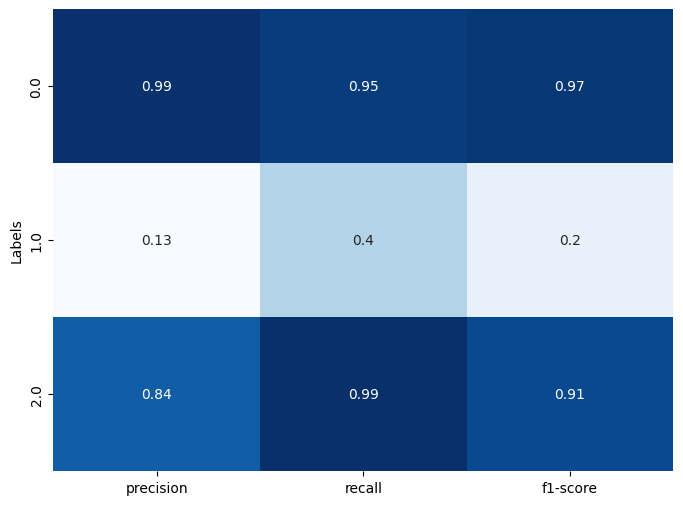

----------
Testing SMOTE
2527/2527 [==============================] - 14s 5ms/step - loss: 0.0906 - sparse_categorical_accuracy: 0.9863 - MAE: 0.3795
test loss, test acc: [0.09056700766086578, 0.9862976670265198, 0.3794688582420349]
2527/2527 [==============================] - 12s 5ms/step
[[76658   188   275]
 [  623   629     5]
 [    1    16  2467]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     77121
         1.0       0.76      0.50      0.60      1257
         2.0       0.90      0.99      0.94      2484

    accuracy                           0.99     80862
   macro avg       0.88      0.83      0.85     80862
weighted avg       0.99      0.99      0.99     80862



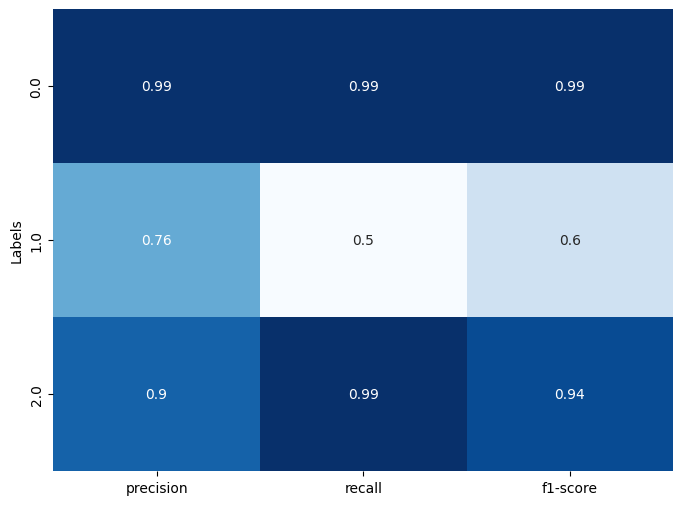

----------
Testing random oversampling
2527/2527 [==============================] - 14s 5ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.9826 - MAE: 0.3795
test loss, test acc: [0.1231667771935463, 0.9825628995895386, 0.3794688582420349]
2527/2527 [==============================] - 12s 5ms/step
[[76352   387   382]
 [  520   632   105]
 [    2    14  2468]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     77121
         1.0       0.61      0.50      0.55      1257
         2.0       0.84      0.99      0.91      2484

    accuracy                           0.98     80862
   macro avg       0.81      0.83      0.82     80862
weighted avg       0.98      0.98      0.98     80862



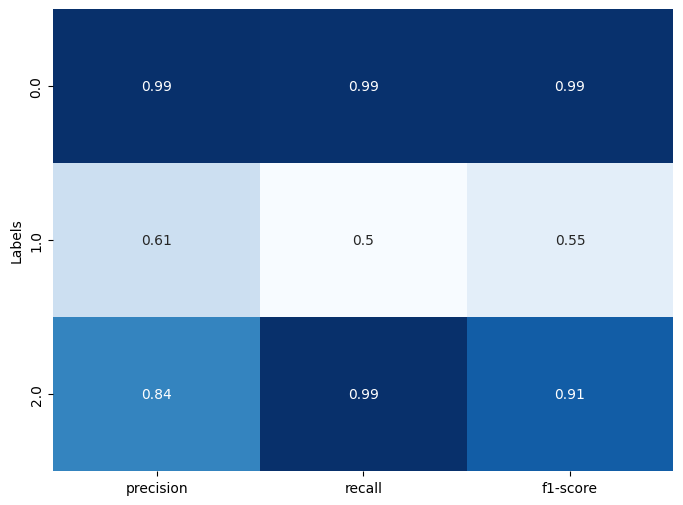

----------
Testing random undersampling
2527/2527 [==============================] - 14s 5ms/step - loss: 0.2918 - sparse_categorical_accuracy: 0.8825 - MAE: 0.3795
test loss, test acc: [0.2918252646923065, 0.8825406432151794, 0.3794688582420349]
2527/2527 [==============================] - 12s 5ms/step
[[67999  8579   543]
 [  315   884    58]
 [    0     3  2481]]
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94     77121
         1.0       0.09      0.70      0.16      1257
         2.0       0.80      1.00      0.89      2484

    accuracy                           0.88     80862
   macro avg       0.63      0.86      0.66     80862
weighted avg       0.98      0.88      0.92     80862



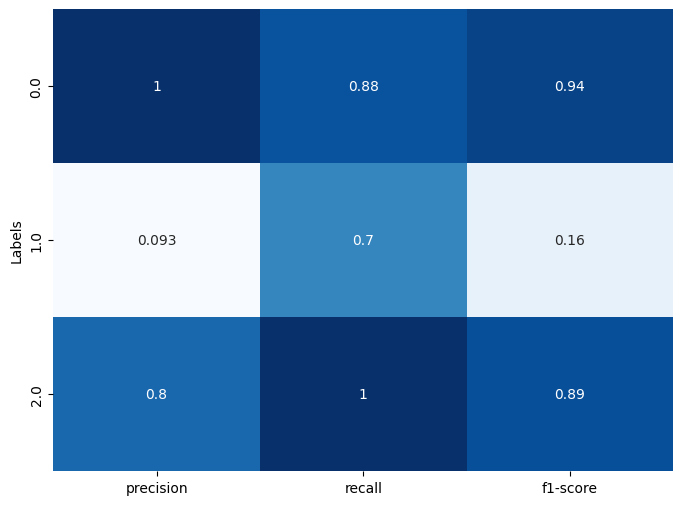

In [ ]:
print("----------")
print("Testing primary model")
test(primary_model)
print("----------")
print("Testing SMOTE")
test(smote_model)
print("----------")
print("Testing random oversampling")
test(random_oversampling_model)
print("----------")
print("Testing random undersampling")
test(random_undersampling_model)